<a href="https://colab.research.google.com/github/amirali200080/color_recognization/blob/main/having_aLotOf_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os

If there is such folder, we don't want it, and we can remove that tree(directory and subdirectories) by running following code:

In [ ]:
import shutil
try:
  shutil.rmtree("datas")
except:
  pass

Here we can list the colors and theyre RGB codes:

In [ ]:
colors = dict()
colors["red"] = (0, 0, 255)
colors["green"] = (0, 255, 0)
colors["blue"] = (255, 0, 0)
colors["white"] = (255, 255, 255)
colors["black"] = (0, 0, 0)
colors["brown"] = (33, 67, 101)
colors["orange"] = (0, 195, 255)
colors["yellow"] = (0, 255, 255)

here we are going to make directories(folders):

In [ ]:
list_of_directories = [f"datas/{i}" for i in colors.keys()]
for i in list_of_directories:
  try:
    os.makedirs(i)
  except:
    pass
os.listdir()

['.config', 'datas', 'sample_data']

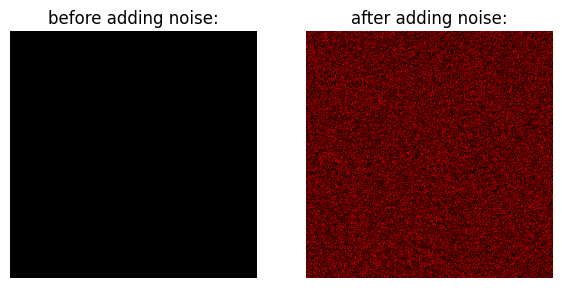

In [ ]:
# making the figure:
whiteblankimage = 255 * np.ones(shape=[512, 512, 3], dtype=np.uint8)
cv2.rectangle(whiteblankimage, pt1=(0,0), pt2=(512, 512), color=(0, 0, 0), thickness=-1)

# Preview:
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(whiteblankimage)
plt.title("before adding noise:")
plt.axis("off")

# Generate random Gaussian noise
mean = 50
stddev = 200
noise = np.zeros(whiteblankimage.shape, np.uint8)
cv2.randn(noise, mean, stddev)
# Add noise to image
whiteblankimage = cv2.add(whiteblankimage, noise)

# Preview:
plt.subplot(1, 2, 2)
plt.imshow(whiteblankimage)
plt.title("after adding noise:")
plt.axis("off")

plt.show()

here we are going to make a 800 example dataset with 8 label and 100 example in each label. in this way we are trying to first add some random noise to all images, then save them:

In [ ]:
for color, RGB_Code in colors.items():
  for i in range(100):
    whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    cv2.rectangle(whiteblankimage, pt1=(0,0), pt2=(256, 256), color=RGB_Code, thickness=-1)

    # Generate random Gaussian noise
    mean = 50
    stddev = np.random.randint(30, 150)
    noise = np.zeros(whiteblankimage.shape, np.uint8)
    cv2.randn(noise, mean, stddev)
    # Add noise to image
    whiteblankimage = cv2.add(whiteblankimage, noise)
    cv2.imwrite(f"datas/{color}/{i}.jpg", whiteblankimage)



#plt.imshow(whiteblankimage)

#plt.show()


In [ ]:
directory = "datas/"

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    validation_split=0.2,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    validation_split=0.2,
    seed=123
)

Found 800 files belonging to 8 classes.
Using 640 files for training.
Found 800 files belonging to 8 classes.
Using 160 files for validation.


In [ ]:
#tf.keras.utils.load_img(
 #   "/content/datas/green/1.jpg",
 #   grayscale=False,
 #   color_mode="rgb",
 #   target_size=None,
 #   interpolation="nearest",
 #   keep_aspect_ratio=False,
#)


In [ ]:
class_names = train_ds.class_names
print(class_names)

['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']


In [ ]:
#print ((list(val_ds.take(1))[0][0][0]))

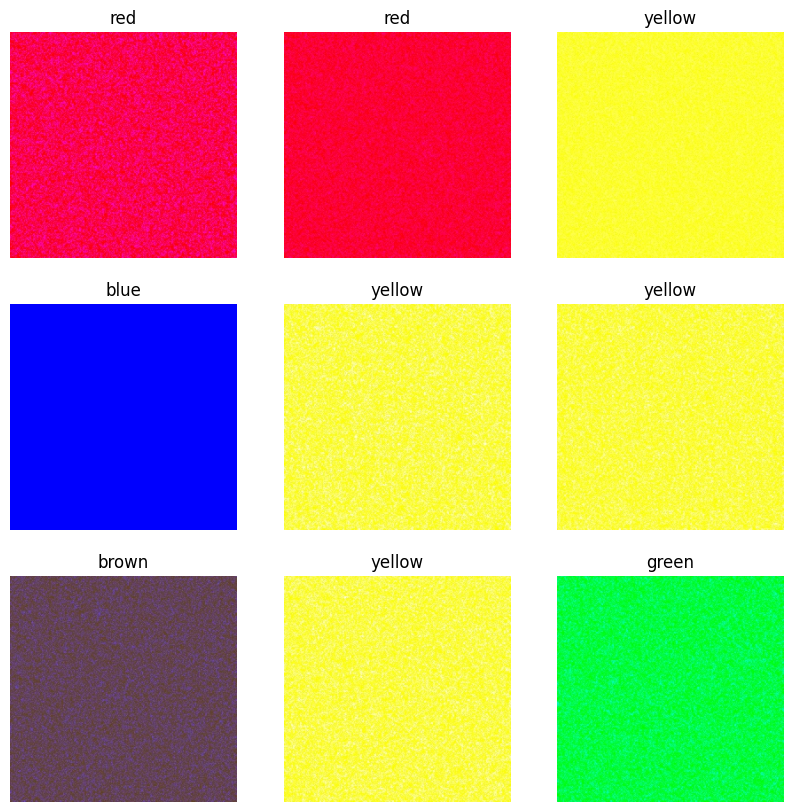

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/6
20/20 [==============================] - 3s 84ms/step - loss: 0.6086 - accuracy: 0.8000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 2/6
20/20 [==============================] - 1s 39ms/step - loss: 8.6786e-04 - accuracy: 1.0000 - val_loss: 1.1157e-04 - val_accuracy: 1.0000
Epoch 3/6
20/20 [==============================] - 1s 37ms/step - loss: 5.9224e-05 - accuracy: 1.0000 - val_loss: 3.6240e-05 - val_accuracy: 1.0000
Epoch 4/6
20/20 [==============================] - 1s 38ms/step - loss: 2.1985e-05 - accuracy: 1.0000 - val_loss: 1.6273e-05 - val_accuracy: 1.0000
Epoch 5/6
20/20 [==============================] - 1s 37ms/step - loss: 1.2579e-05 - accuracy: 1.0000 - val_loss: 1.1661e-05 - val_accuracy: 1.0000
Epoch 6/6
20/20 [==============================] - 1s 37ms/step - loss: 9.0854e-06 - accuracy: 1.0000 - val_loss: 9.1319e-06 - val_accuracy: 1.0000


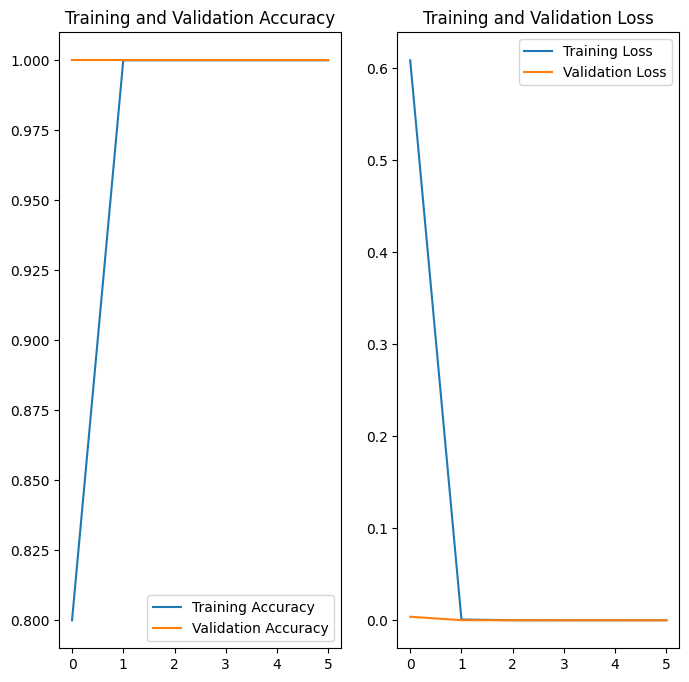

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1156/1156 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


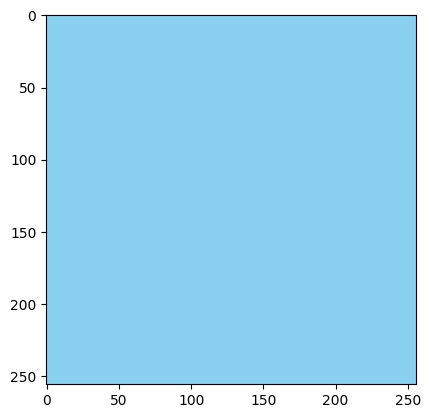

1/1 [==============================] - 0s 21ms/step
This image most likely belongs to white with a 92.90 percent confidence.


In [ ]:
#img = cv2.rectangle(whiteblankimage, pt1=(0,0), pt2=(512, 512), color=(0,0,255), thickness=-1)
color_url = "https://htmlcolorcodes.com/assets/images/colors/baby-blue-color-solid-background-1920x1080.png"
color_path = tf.keras.utils.get_file('Blue', origin=color_url)

#color_url = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARMAAAC3CAMAAAAGjUrGAAAAG1BMVEX/AAD/i47IAAT/PUHcAAX/kJP/NTn/QETZAAUkBiP4AAABAUlEQVR4nO3QSQ0AIBAEsOXGv2I8zI+kldBqkbVH4lTmzkjPlBMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnTpw4ceLEiRMnH5489COT89vAjEAAAAAASUVORK5CYII="
#color_path = tf.keras.utils.get_file('Red', origin=color_url)

#color_url = "https://img.freepik.com/free-photo/solid-brown-concrete-textured-wall_53876-124585.jpg"
#color_path = tf.keras.utils.get_file('darkBrown', origin=color_url)



img = tf.keras.utils.load_img(
    color_path, target_size=(256, 256)
)
plt.imshow(img)
plt.show()
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
#img_array = img_array.reshape((1, 28, 28))

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
#del img2
del sunflower_path
del sunflower_url
del img